## Data Visualization

In [1]:
# Dependencies and packages
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import datetime as dt
import pandas as pd
import geopandas as gpd
import plotly.figure_factory as ff
from matplotlib.collections import PatchCollection
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the shared mobility data csv
# csvpath = os.path.join("/Users/sheetalbongale/Scooters_In_Austin_Data_Analysis/resources/merged_sharedmobility.csv")

csvpath = os.path.join("../../resources/merged_sharedmobility.csv")

df = pd.read_csv(csvpath, index_col=0, low_memory=False)

## What days of the week?

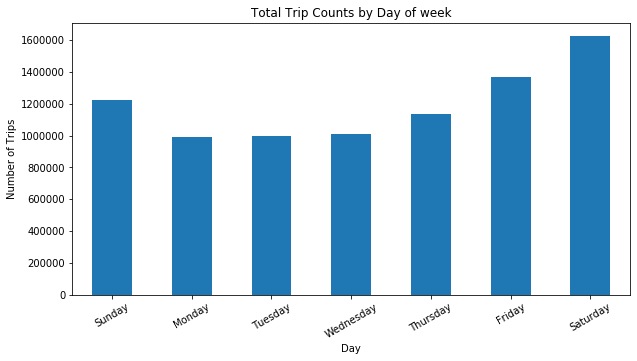

In [4]:
# Count trips per day and sort by day:
daily_total = pd.DataFrame(df["Day Of Week"].value_counts().sort_index())

# Map day of week with actual names:
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
daily_total['Day'] = days

# Plot glyph: 
daily_total.plot(kind="bar", x="Day", y="Day Of Week", title="Total Trip Counts by Day of week", figsize = (10,5), rot= 30, legend=False)
plt.ylabel("Number of Trips")
plt.savefig("Plots/trips_per_week.png")
plt.show()

## Which hours of the day are popular?

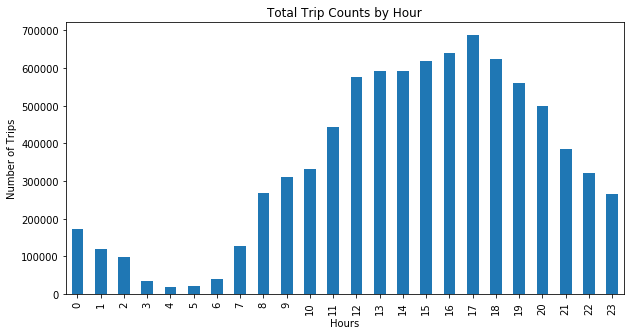

In [75]:
# Count trips per hour and sort by hour:
hourly_total = pd.DataFrame(df['Hour'].value_counts().sort_index())

hourly_total.reset_index().plot(kind='bar', 
                                x='index', 
                                y='Hour', 
                                title='Total Trip Counts by Hour', 
                                figsize = (10,5), legend=False)
plt.xlabel('Hours')
plt.ylabel('Number of Trips')
plt.savefig("Plots/trips_per_hour.png")
plt.show()
#now shows correct plot with sorted xticks

## Are some months more popular than others?

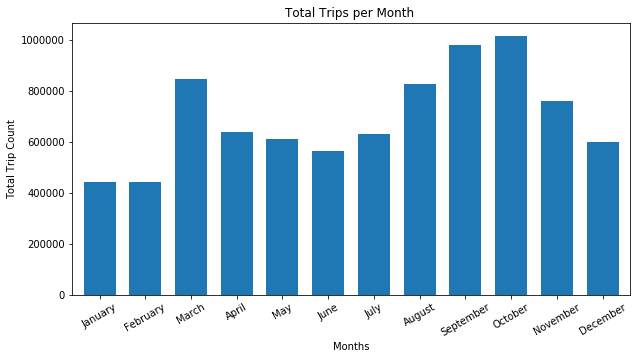

In [145]:
monthly_total = pd.DataFrame(df['Month'].value_counts()).sort_index()
import calendar
mn=[calendar.month_name[int(x)] for x in monthly_total.index.values.tolist()]

monthly_chart = monthly_total.plot.bar(title = "Total Trips per Month ",width = 0.7,figsize = (10,5),rot = 30, legend = False)
monthly_chart.set_xticklabels(mn)
monthly_chart.set_xlabel("Months")
monthly_chart.set_ylabel("Total Trip Count")
plt.savefig("Plots/trips_per_month1.png")
plt.show()
#now shows correct plot with sorted months

## Number of Scooter vs Bicycle Rides per month?

In [ ]:
vehicle_type = df[["Vehicle Type", "Month", "Trip Distance"]].groupby(["Vehicle Type","Month"]).sum()
vehicle_type.reset_index(inplace=True)
vehicle_type

In [ ]:
vehicle_df = vehicle_type.pivot(index="Vehicle Type", columns="Month", values="Trip Distance")
vehicle_df

Text(0, 0.5, 'Number of Trips')

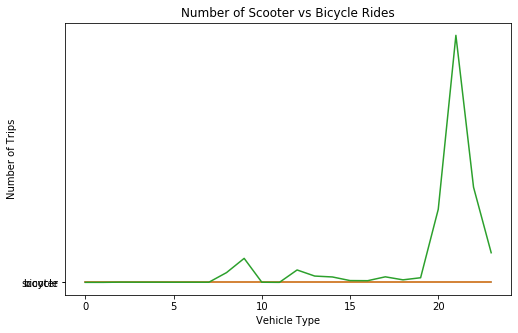

In [173]:
fig, ax = plt.subplots(figsize=(8,5))
#vehicle_df.unstack().plot(ax=ax)
for vehicle in vehicle_type.columns:
    vehicle_plot = plt.plot(vehicle_type.index, vehicle_type[vehicle])
#plot = ax.bar(vehicle_type.index, vehicle_type['Trip Distance'])
#plot2 = ax.bar(vehicle_type.index,vehicle_type['Trip Distance'])
plt.title('Number of Scooter vs Bicycle Rides')
plt.xlabel('Vehicle Type')
plt.ylabel('Number of Trips')
# STILL SHOWS WRONG PLOT

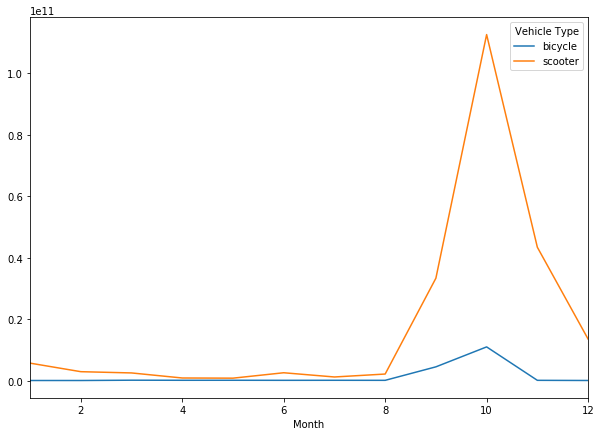

In [179]:
# Another try:

fig, ax = plt.subplots(figsize=(10,7))
df.groupby(['Month','Vehicle Type']).sum()['Trip Distance'].unstack().plot(ax=ax)
# STILL SHOWS WRONG PLOT

## Which census tracts have the most traffic?

In [6]:
# Count how many trips started in each census GEOID tract
census_trip_start = pd.DataFrame(df['Census GEOID Start'].value_counts())
census_trip_start.head(10)

,Census GEOID Start
48453001100,3236435
48453000601,748545
48453000603,601132
48453000604,514316
48453001305,510164
48453000902,456009
48453001200,386962
48453000700,232937
48453001303,204956
48453001401,183566


In [7]:
# Count how many trips ended in each census GEOID tract
census_trip_end = pd.DataFrame(df['Census GEOID End'].value_counts())

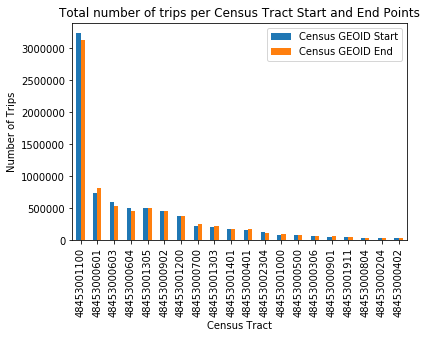

In [39]:
# Only for top 20 popular census tracts
census_traffic = census_trip_start.join(census_trip_end, how='inner')
census_traffic.head(20).plot(kind='bar')
plt.title('Total number of trips per Census Tract Start and End Points')
plt.xlabel('Census Tract')
plt.ylabel('Number of Trips')
plt.savefig("Plots/trips_per_censustract.png")
plt.show()

## Popular Census Tracts using Geopandas

In [3]:
# Plot the census tracts from the US Census Bureau's shapefile using geopandas.
map_df = gpd.read_file('/Users/sheetalbongale/Scooters_In_Austin_Data_Analysis/resources/tl_2010_48453_tract00/tl_2010_48453_tract00.shp')
map_df.head()

,STATEFP00,COUNTYFP00,TRACTCE00,CTIDFP00,NAME00,NAMELSAD00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,geometry
0,48,453,001766,48453001766,17.66,Census Tract 17.66,G5020,S,279772166,7922100,+30.5486598,-097.9935380,"POLYGON ((-97.95351 30.47734, -97.95502 30.476..."
1,48,453,002413,48453002413,24.13,Census Tract 24.13,G5020,S,1345937,0,+30.1971090,-097.7402767,"POLYGON ((-97.74223 30.20387, -97.74159 30.204..."
2,48,453,002412,48453002412,24.12,Census Tract 24.12,G5020,S,1389365,0,+30.1894059,-097.7514898,"POLYGON ((-97.75452 30.18663, -97.75470 30.186..."
3,48,453,002411,48453002411,24.11,Census Tract 24.11,G5020,S,3964067,0,+30.2052875,-097.7488784,"POLYGON ((-97.74159 30.20493, -97.74223 30.203..."
4,48,453,002410,48453002410,24.10,Census Tract 24.10,G5020,S,1212315,0,+30.2057643,-097.7866656,"POLYGON ((-97.78695 30.21097, -97.78689 30.211..."


In [168]:
polygon_lookup = map_df[["CTIDFP00", "geometry"]].set_index("CTIDFP00")["geometry"].to_dict()

In [169]:
def get_center_from_polygon(polygon):
    x = polygon.centroid.x
    y = polygon.centroid.y
    return x, y

In [170]:
def get_center_from_tract_id(id):
    return get_center_from_polygon(polygon_lookup[id])

In [173]:
get_center_from_tract_id(48453002410)

(-97.78666542812522, 30.205764476603573)

In [155]:
census_trip_end

,Census GEOID End
48453001100,3127996
48453000601,821871
48453000603,541187
48453001305,509031
48453000902,459271
...,...
48491020310,1
48491020317,1
48453001733,1
48453001764,1


In [145]:
get_center_from_polygon(map_df["geometry"][0])

(-97.99812630645184, 30.539390025720902)

In [ ]:
get_ceploygon

In [4]:
for idx, row df.iterrows()

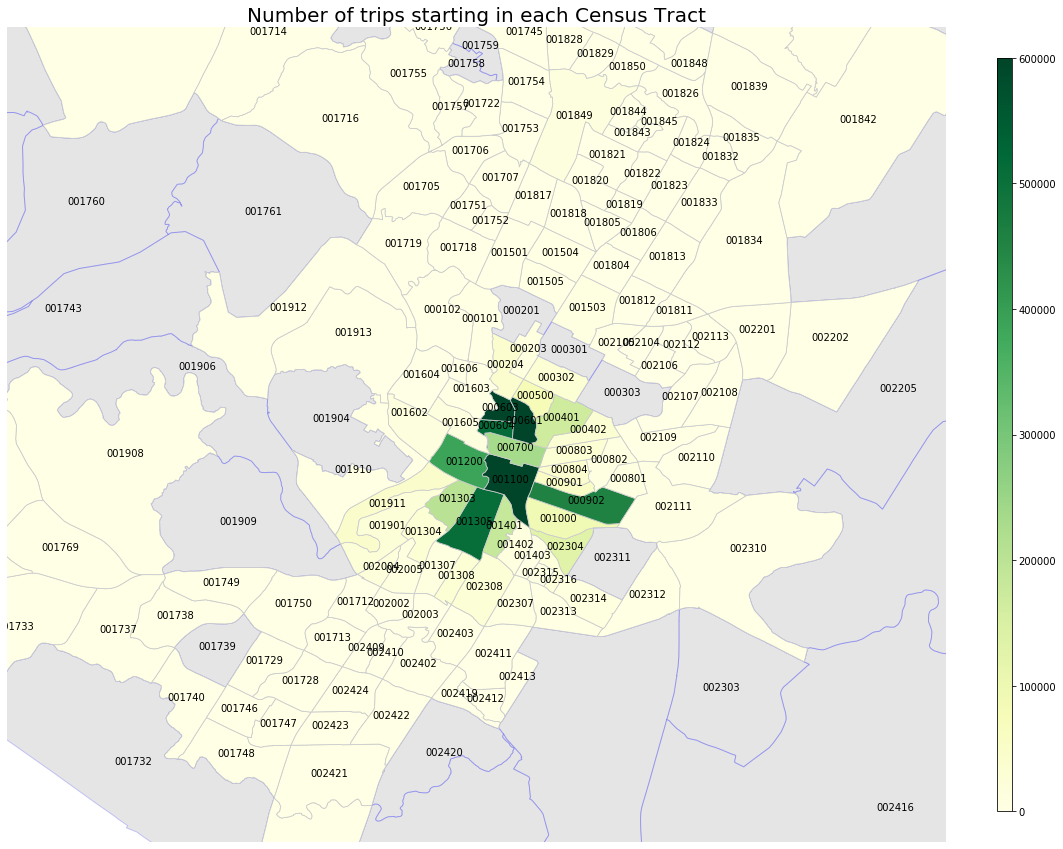

In [15]:
# Create a plot using geopandas andchloropleth of census tract starts
from shapely.geometry import Point, LineString
fig, ax = plt.subplots(figsize=(18, 18))
#ax_start = map_df.plot(color='0.9', figsize=(18, 18))

#census_trip_start['CTIDFP00'] = census_trip_start['Census GEOID Start']
map_df['CTIDFP00'] = map_df['CTIDFP00'].astype('int64')
map_df[['INTPTLAT00','INTPTLON00']]= map_df[['INTPTLAT00','INTPTLON00']].astype('float64')

# Merge the geodataframe with the census starts dataframe
starts_plot = map_df.set_index('CTIDFP00').join(census_trip_start, how='inner')

vmax_start = 600000
vmin_start = 0
# Render the glyphs:
map_df.plot(ax=ax, color='grey', edgecolor='blue', alpha=0.2)
starts_plot.plot(ax=ax, 
                 column='Census GEOID Start', 
                 cmap='YlGn', 
                 linewidth=0.8, 
                 edgecolor='0.8', 
                 vmax=vmax_start, 
                 vmin=vmin_start
                )

# Label census tracts
for idx, row in map_df.iterrows():
    plt.annotate(s=row['TRACTCE00'], 
                 xy=(row['INTPTLON00'], row['INTPTLAT00']), 
                 horizontalalignment='center', 
                 clip_on=True
                )

# Set the limits of the plot
bbox = (-97.919881, -97.589348, 30.139918,30.426626)
plt.xlim(bbox[0], bbox[1])
plt.ylim(bbox[2], bbox[3])

plt.axis('off')
plt.title('Number of trips starting in each Census Tract',fontsize=20)
sm_start = plt.cm.ScalarMappable(cmap='YlGn', norm=plt.Normalize(vmin=vmin_start, vmax=vmax_start))

plt.colorbar(sm_start, fraction=0.015, aspect=50)

plt.show()

## Which Zipcodes have the most traffic?

In [101]:
# Count how many trips started in each census GEOID tract
zipcode_start = pd.DataFrame(df['Zipcode Start'].value_counts())

In [102]:
# Count how many trips ended in each census tract
zipcode_end = pd.DataFrame(df['Zipcode End'].value_counts())

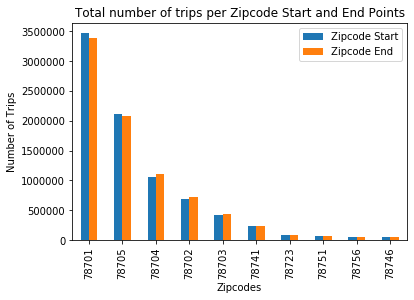

In [104]:
# Only for top 10 popular zipcodes
zipcode_traffic = zipcode_start.join(zipcode_end, how='inner')
zipcode_traffic.head(10).plot(kind='bar')
plt.title('Total number of trips per Zipcode Start and End Points')
plt.xlabel('Zipcodes')
plt.ylabel('Number of Trips')
plt.savefig("Plots/trips_per_zipcode.png")
plt.show()

## What routes are taken to start/end a trip? 

In [29]:
from shapely.geometry import Point, LineString

census = gpd.read_file('/Users/sheetalbongale/Scooters_In_Austin_Data_Analysis/resources/census_tracts_2010_msa/census_tracts_2010_msa.shp')
streets = gpd.read_file('/Users/sheetalbongale/Scooters_In_Austin_Data_Analysis/resources/Street Centerline/geo_export_c8b73b25-2ed4-4cce-b27a-5b77fe19ba06.shp')
streets = streets.to_crs(census.crs)

/Users/sheetalbongale/.local/share/virtualenvs/Python-Practice-Codes-ComU94dP/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.



In [33]:
census.dtypes

TRACTCE10       object
SUM_totpop     float64
SUM_white      float64
SUM_black      float64
SUM_hispan     float64
SUM_asian      float64
SUM_other      float64
SUM_multi      float64
SUM_hu_tot     float64
SUM_hu_occ     float64
SUM_hu_vac     float64
SUM_age18p     float64
SUM_age55_     float64
SUM_age65_     float64
SUM_age74_     float64
SUM_OWN_OC     float64
SUM_REN_OC     float64
SUM_AGE_0_     float64
SUM_AGE_5_     float64
SUM_AGE_10     float64
SUM_AGE_15     float64
SUM_AGE_18     float64
SUM_AGE_20     float64
SUM_AGE_25     float64
SUM_AGE_35     float64
SUM_AGE_45     float64
SUM_AGE_46     float64
SUM_AGE50_     float64
SUM_AGE_60     float64
SUM_AGE_55     float64
SUM_AGE60_     float64
SUM_AGE62_     float64
SUM_AGE651     float64
SUM_AGE_65     float64
SUM_AGE75_     float64
SUM_AGE80_     float64
SUM_AGE_85     float64
SUM_FAMSWC     float64
SUM_POP_IN     float64
SUM_FAMILI     float64
SUM_NONFAM     float64
geometry      geometry
dtype: object

In [22]:
streets.head()

,geometry
0,"LINESTRING (-97.68217 30.31111, -97.68202 30.3..."
1,"LINESTRING (-97.83916 30.52056, -97.83916 30.5..."
2,"LINESTRING (-97.89384 30.37534, -97.89434 30.3..."
3,"LINESTRING (-97.76743 30.13483, -97.76796 30.1..."
4,"LINESTRING (-97.84643 30.56331, -97.84806 30.5..."


## Second try

In [14]:
census_geo_453 = census[census.COUNTYFP=='453']
census_geo_453 = census_geo_453.set_index("GEOID")['geometry'].to_crs(epsg=2277)
census_geo_453.head()

/Users/sheetalbongale/.local/share/virtualenvs/Python-Practice-Codes-ComU94dP/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.



GEOID
48453000402    POLYGON ((3118249.290 10074643.057, 3118460.90...
48453001912    POLYGON ((3078443.549 10087054.072, 3078461.34...
48453001916    POLYGON ((3052991.248 10082852.302, 3053034.30...
48453001783    POLYGON ((3066081.337 10086004.517, 3066082.87...
48453001918    POLYGON ((3087077.474 10078732.111, 3087092.93...
Name: geometry, dtype: geometry

In [60]:
tract_count = df['Census GEOID Start'].value_counts()
tract_count

48453001100    3236435
48453000601     748545
48453000603     601132
48453000604     514316
48453001305     510164
                ...   
48491020509          1
48491020323          1
48021950100          1
48491020603          1
48491021502          1
Name: Census GEOID Start, Length: 246, dtype: int64

In [63]:
census_gdf = gpd.GeoDataFrame(geometry = census, data = census_trip_start['Census GEOID Start'])
fig, ax = plt.subplots(figsize=(10,10))
ax.set(aspect='equal', xticks=[], yticks=[])
census_gdf.plot(column= 'Census GEOID Start', ax = ax, cmap='Purples', legend=True)
plt.title('Popular rides Census Tract', size = 14)

ValueError: Must pass array with one dimension only.